In [74]:
import itertools
from tqdm import tqdm
from time import sleep
from math import sqrt
from multiprocessing import Pool

import matplotlib
from matplotlib import pyplot as plt

import numpy as np

font = {'size'   : 25}

matplotlib.rc('font', **font)
matplotlib.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"]= 10, 6
matplotlib.rcParams['lines.linewidth'] = 3


deltaD = 0.1

Defines and evaluates denominators in the RG equations. The denominators in the RG equations are
$$
d_0 = \omega - \frac{1}{2}\left(D - \mu\right) - \frac{U}{2} + \frac{K}{2}
$$
$$
d_1 = \omega - \frac{1}{2}\left(D - \mu\right) + \frac{U}{2} + \frac{J}{2}
$$
$$
d_2 = \omega - \frac{1}{2}\left(D - \mu\right) + \frac{J}{4} + \frac{K}{4}
$$

In [ ]:
def den(w, D, U, J, K):
    d0 = w - 0.5 * D - U/2 + K/2
    d1 = w - 0.5 * D + U/2 + J/2
    d2 = w - 0.5 * D + J/4 + K/4
    return np.array([d0, d1, d2])

# RG Equations

The RG equations for the symmetric spin-charge Anderson-Kondo are 

$$
\Delta U = 4|V|^2 \left[\frac{1}{\omega - \frac{1}{2}\left(D - \mu\right) + \frac{U}{2} + \frac{1}{2}J}  - \frac{1}{\omega - \frac{1}{2}\left(D - \mu\right) - \frac{U}{2} + \frac{1}{2}K}\right] + \sum_{k<\Lambda_j} \frac{3}{4}\frac{K^2 - J^2}{\omega - \frac{1}{2}\left(D - \mu\right) + \frac{1}{4}J + \frac{1}{4}K}
$$

$$
\Delta V = \frac{V K}{16}\left(\frac{1}{\omega - \frac{1}{2}\left(D - \mu\right) - \frac{U}{2} + \frac{1}{2}K} + \frac{1}{\omega - \frac{1}{2}\left(D - \mu\right) + \frac{1}{4}J + \frac{1}{4}K} \right) - \frac{3VJ}{4}\left( \frac{1}{\omega - \frac{1}{2}\left(D - \mu\right) + \frac{U}{2} + \frac{1}{2}J} + \frac{1}{\omega - \frac{1}{2}\left(D - \mu\right) + \frac{1}{4}J + \frac{1}{4}K} \right)
$$

$$
\Delta J = - J^2\left(\omega - \frac{1}{2}\left(D - \mu\right) + \frac{1}{4}J + \frac{1}{4}K\right)^{-1}
$$

$$
\Delta K = - K^2\left(\omega - \frac{1}{2}\left(D - \mu\right) + \frac{1}{4}J + \frac{1}{4}K\right)^{-1}
$$

The following equation accepts the coupling values at the $j^{th}$ step of the RG, applies the RG equations on them and returns the couplings for the $(j-1)^{th}$ step. _If any coupling changes sign, it is set to 0._

In [80]:

def rg(w, D, U, V, J, K, flags):
    rho = 2/deltaD
    n = rho*deltaD
    dens = den(w, D, U, J, K)
    deltaU = int(flags[2])*(-4 * V**2 * (1/dens[0] - 1/dens[1]) - (3* (J**2 - K**2)/8) * (D*n/deltaD) / dens[2])
    deltaV = int(flags[2])*((1/16) * K * V * (1/dens[0] - 1/dens[2]) - (3/4) * J * V * (1/dens[1] + 1/dens[2]))
    deltaJ = - int(flags[2]) * J**2 / dens[2]
    deltaK = - int(flags[2]) * K**2 / dens[2]

    U = 0 if (U + n*deltaU) * U <= 0 else U + n*deltaU
    V = 0 if (V + n*deltaV) * V <= 0 else V + n*deltaV
    J = 0 if (J + n*deltaJ) * J <= 0 else J + n*deltaJ
    K = 0 if (K + n*deltaK) * K <= 0 else K + n*deltaK

    return U, V, J, K

The following function does one complete RG for a given set of bare couplings and returns arrays of the flowing couplings.

In [103]:
def complete_RG(w, D0, U0, V0, J0, K0):
    U = [U0]
    V = [V0]
    J = [J0]
    K = [K0]
    E = [D0]
    old_den = den(w, D0, U[-1], J[-1], K[-1])
    for D in np.arange(D0, 0, -deltaD):
        w = -D0/2
        new_den = den(w, D, U[-1], J[-1], K[-1])
        flags = old_den * new_den > 0
        if not flags[2]:
            break
        old_den = new_den
        U_j, V_j, J_j, K_j = rg(w, D, U[-1], V[-1], J[-1], K[-1], flags)
        U.append(U_j)
        V.append(V_j)
        J.append(J_j)
        K.append(K_j)
        E.append(D - deltaD)
        
    return E,U,V,J,K

# 1. $V=0$

First we will look at the simplified case of $V=0$. Since the RG equation for $V$ involves $V$, it will not flow. We need to look only at $U$, $J$ and $K$. Depending on the value of $\omega$, the denominator can be either positive or negative. We look at the two cases separately.

## a. $\omega - \frac{\epsilon_q}{2} + \frac{1}{4}J + \frac{1}{4}K>0$ (high $\omega$):

These aren't truly URG fixed points because the denominator will not converge towards zero.

### i. $J=K$

Since $\Delta U \propto K^2 - J^2$, $U$ will be marginal here.

In [ ]:
D0 = 20
w = D0
U0 = 1
J0 = K0 = 0.1
V0 = 0
E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
steps = np.array(E)/D0
fig, ax = plt.subplots(1,2,figsize=(16, 6))
ax[0].set_ylabel(r'$U$')
ax[0].set_xlabel(r'RG Step')
ax[0].plot(steps, U)
ax[1].set_ylabel(r'$J$')
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].set_xlabel(r'RG Step')
ax[1].plot(steps, J)
plt.suptitle(r"$J_0=K_0={}, U_0={}, \omega = {}, D_0 = {}$".format(J0, U0, w, D0), y=0.91)
plt.tight_layout()
plt.show()


### ii. $J > K$

$U$ will be irrelevant here.

In [ ]:
deltaD = 0.1
D0 = 20
w = D0
U0 = 1
J0 = 0.01
K0 = 0.009
V0 = 0
E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
steps = np.array(E)/D0

fig, ax = plt.subplots(1,3)
fig.set_size_inches(24,6)
ax[0].set_ylabel(r'$J$')
ax[0].set_xlabel(r'RG Step')
ax[0].plot(steps, J)
ax[1].set_ylabel(r'$K$')
ax[1].set_xlabel(r'RG Step')
ax[1].plot(steps, K)
ax[2].set_ylabel(r'$U$')
ax[2].set_xlabel(r'RG Step')
ax[2].plot(steps, U)
plt.suptitle(r"$J_0=K_0={}, U_0={}$".format(J0, U0), y=0.91)
plt.tight_layout()
plt.show()

### iii. $J < K$

$U$ will be relevant here.

In [ ]:
D0 = 20
w = D0
U0 = 1
J0 = 0.01
K0 = 0.02
V0 = 0

E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
steps = np.array(E)/D0

fig, ax = plt.subplots(1,2)
fig.set_size_inches(16, 6)
ax[0].set_ylabel(r'$U$')
ax[0].set_xlabel(r'RG Step')
ax[0].plot(steps, U)
ax[1].set_ylabel(r'$J$')

ax[1].set_xlabel(r'RG Step')
ax[1].plot(steps, J)
plt.suptitle(r"$J_0=K_0={}, U_0={}$".format(J0, U0), y=0.91)
plt.tight_layout()
plt.show()


## b. $\omega - \frac{\epsilon_q}{2} + \frac{1}{4}J + \frac{1}{4}K<0$ (low $\omega$):

This is the regime where we achieve true strong-coupling fixed points in $J,K$. The signature of $K^2 - J^2$ will determine whether $U$ is relevant or irrelevant.

### i. $J>K$

In [ ]:
w = -D0/2
D0 = 10
U0 = 0.01
J0 = 0.05
K0 = 0.04
V0 = 0

E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
steps = np.array(E)/D0

fig, ax = plt.subplots(1,3)
fig.set_size_inches(24, 6)
ax[0].set_ylabel(r'$K$')
ax[0].set_xlabel(r'RG Step')
ax[0].plot(steps, K)

ax[1].set_ylabel(r'$J$')
ax[1].set_xlabel(r'RG Step')
ax[1].plot(steps, J)

ax[2].set_ylabel(r'$U$')
ax[2].set_xlabel(r'RG Step')
ax[2].plot(steps, U)

for ax in ax:
    ax.set_yscale("log")
plt.suptitle(r"$J_0={}, K_0={}, U_0={}, \omega={}$".format(J0, K0, U0, w), y=0.91)
plt.tight_layout()
plt.show()

### i. $J<K$

In [ ]:
w = -D0/2
D0 = 10
U0 = 1
J0 = 0.05
K0 = 0.06
V0 = 0

E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
steps = np.array(E)/D0

plt.ylabel(r'$U$')
plt.xlabel(r'RG Step')
plt.plot(steps, U)
plt.title(r"$J_0={}, K_0={}, U_0={}, \omega={}$".format(J0, K0, U0, w))
plt.show()
plt.ylabel(r'$J$')
plt.xlabel(r'RG Step')
plt.plot(steps, J)
plt.show()

To wrap up the $V=0$ case, we look at an RG-invariant:

$\frac{\Delta J}{\Delta K} = \frac{J^2}{K^2} \implies \frac{1}{J} - \frac{1}{K} = \frac{1}{J_0} - \frac{1}{K_0}$

Note that this is an invariant even when $V$ is turned on.

In [ ]:
w = 0
D0 = 10
U0 = 1
J0 = 0.01
K0 = 0.02
V0 = 0
E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
plt.xlabel(r"$K$")
plt.ylabel(r"$J$")
plt.plot(K, J, label=r'$J<K$')
J0 = 0.02
K0 = 0.01
E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
plt.plot(K, J, label=r'$J>K$')
J0 = 0.01
K0 = 0.01
E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
plt.plot(K, J, label=r'$J=K$')
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title(r"$\omega = {}, U_0 = {}, D_0={}$".format(w, U0, D0))
plt.show()

# 2. $V > 0$

The inclusion of $V$ will mean that there will not by any sharply defined phase of $U^*$ any more. We will still be working in the regime where $J,K$ flow to strong-coupling, and since those RG equations do not depend on $V$, their flows are unchanged. The behaviour of $U$ will get complicated however. To make 
sense, we will see how the total (over a range of $\omega$ and bare $U$) number of fixed points where $U^* > U_0$ and the total number of fixed points where $U^* < U_0$, in each of the four quadrants of the phase diagram, varies against the bare value $V_0$.

In [ ]:
D0 = 20
V0 = 0.1
J0 = 0.01
K0 = 0
w = 0

for U0 in [1.5, 0.5, 0.05, 0]:
    E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
    J = np.array(J)
    U = np.array(U)

    if U0 != 0:
        plt.plot(J[np.where(U > 0)], U[np.where(U > 0)], label=r"$U_0 = {}$".format(U0))
        rang = len(J[np.where(U > 0)])
    else:
        plt.plot(J[:rang], U[:rang], label=r"$U_0 = {}$".format(U0))
    plt.ylabel(r"$U$")
    plt.xlabel(r"$J$")
plt.legend()
plt.title(r"$V_0 = {}, J_0 = {}, K_0 = {}, D_0 = {}, \omega = {}$".format(V0, J0, K0, D0, w))
plt.show()


In [ ]:
def plot(x, y, xlabel, ylabel, ax):
    ax.plot(x,y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    
D0 = 20
V0 = 0.1
J0 = 0.01
K0 = 0
w = 0
U0 = 0.1

E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
steps = np.array(E)/D0

fig, ax = plt.subplots(2,2, figsize=(16,12))

plot(steps, U, r"RG steps", r"$U$", ax[0][0])
plot(steps, V, r"RG steps", r"$V$", ax[0][1])
plot(steps, J, r"RG steps", r"$J$", ax[1][0])
plot(steps, K, r"RG steps", r"$K$", ax[1][1])
ax[0][1].set_yscale("log")
ax[1][0].set_yscale("log")
plt.tight_layout()
plt.suptitle(r"$U_0 = {}, V_0 = {}, J_0 = {}, K_0 = {}, D_0 = {}, \omega = {}$".format(U0, V0, J0, K0, D0, w), y=1)
plt.show()

In [ ]:
def plot(x, y, xlabel, ylabel, ax):
    ax.plot(x,y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

D0 = 20
V0 = 0.1
J0 = 0.01
K0 = 0
w = 0
U0 = 0.01

E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
steps = np.array(E)/D0
U = np.array(U)
V = np.array(V)
J = np.array(J)

fig, ax = plt.subplots(1,2, sharey=True, figsize=(14,5))

plot(J[U>0], U[U>0], r"$J$", r"$U$", ax[0])
plot(V[U>0], U[U>0], r"$V$", r"$U$", ax[1])

plt.suptitle(r"$U_0 = {}, V_0 = {}, J_0 = {}, K_0 = {}, D_0 = {}, \omega = {}$".format(U0, V0, J0, K0, D0, w), y=0.94)
plt.show()

In [ ]:
def plot(x, y, xlabel, ylabel, ax):
    ax.plot(x,y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_yscale("log")
    

D0 = 20
V0 = 0.01
J0 = 0
K0 = 0.01
w = 0
U0 = -0.1

E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
steps = np.array(E)/D0

fig, ax = plt.subplots(1,2, figsize=(16, 6))

plot(steps, -np.array(U), r"RG steps", r"$-|U|$", ax[0])
plot(steps, K, r"RG steps", r"$K$", ax[1])

plt.suptitle(r"$U_0 = {}, V_0 = {}, J_0 = {}, K_0 = {}, D_0 = {}, \omega = {}$".format(U0, V0, J0, K0, D0, w), y=0.9)
fig.tight_layout()
plt.show()

## Scaling of $J^*$ and $V^*$ with system size

In [ ]:
def plot(y, ylabel, y0=[]):
    N = D0_range * 10
    plt.plot(N, y, color="r")
    plt.scatter(N, y, color="b", marker="o")
    if len(y0) != 0:
        plt.plot(N, y0, color="g", label=r"$y_0$")
        plt.legend()
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel(r"$N$")
    plt.title(r"$V_0 = {}, U_0 = {}, J_0 = {}$".format(V0, U0, J0))
    plt.ylabel(ylabel)
    plt.show()
    
def JV_D(D0_range, V0, K0, U0, J0):
    Jstar = []
    Vstar = []
    Kstar = []
    Ustar = []
    j = []
    k = []
    v = []
    for D0 in tqdm(D0_range):
        w = 0 # 0.9 * (D0/2 - abs(U0)/2 - max(J0,K0)/2)
        E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
        Ustar.append(U[-1])
        Jstar.append(J[-1])
        Kstar.append(K[-1])
        Vstar.append(V[-1])
        count = E[-1]/deltaD
        j.append(J[-1] * count)
        k.append(K[-1] * count)
        v.append(V[-1] * sqrt(count))

    plot(Jstar, r"$J^*$")
    plot(Vstar, r"$V^*$")
    plot(j, "j")
    plot(k, "k")
    plot(v, "v")

### First Quadrant

In [ ]:
V0 = 0.1 
K0 = 0.1
U0 = 0.1
J0 = 0.2
D0_range = 10**np.arange(1,7.1,2)
JV_D(D0_range, V0, K0, U0, J0)

## Scaling of $\gamma$ with system size

100%|██████████| 21/21 [00:02<00:00,  9.16it/s] 


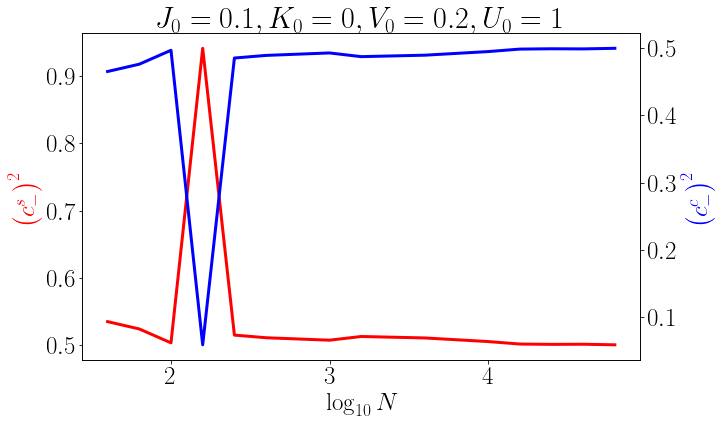

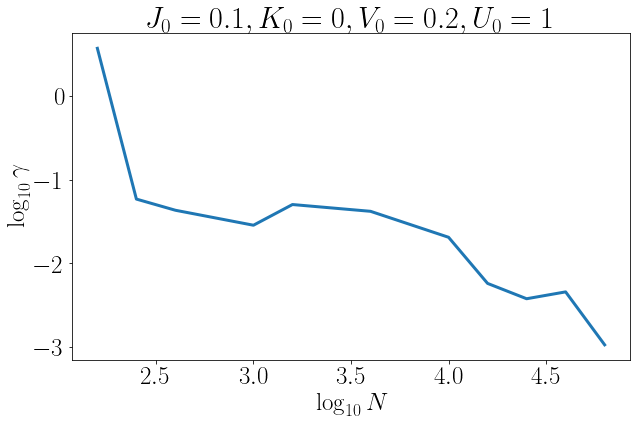

In [106]:
D0_range = 10**np.arange(0,4.1,0.2)
J0 = 0.1
V0 = 0.2
K0 = 0
U0 = 1
c1sq = []
c2sq = []
gamma_arr = []
size = []
for D0 in tqdm(D0_range):
    w = -D0
    E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
    count = E[-1]*2/deltaD
    if count <=0:
        count = 1
    j = J[-1] * count
    k = K[-1] * count
    v = V[-1] * sqrt(count)
    U = U[-1]
    if v != 0:
        gamma = ((3*j+k)/4 + U/2)/(2*v)
        gamma_arr.append(gamma)
        c1sq.append((sqrt(gamma**2 + 4) + gamma)/(2 * sqrt(gamma**2 + 4)))
        c2sq.append((sqrt(gamma**2 + 4) - gamma)/(2 * sqrt(gamma**2 + 4)))
        size.append(np.log10(D0*10))

fig, ax = plt.subplots()
ax.plot(size, (c1sq), color="r")
ax.set_xlabel(r"$\log_{10}N$")
ax.set_ylabel(r"$\left( c^s_- \right)^2$", color="r")
ax2 = ax.twinx()
ax2.plot(size, (c2sq), color="b")
ax2.set_xlabel(r"$\log_{10}N$")
ax2.set_ylabel(r"$\left( c^c_- \right)^2$", color="b")
plt.title(r"$J_0 = {}, K_0 = {}, V_0 = {}, U_0 = {}$".format(J0, K0, V0, U0))
plt.show()
plt.plot(size[3:], np.log10(gamma_arr)[3:])
plt.ylabel(r"$\log_{10}\gamma$")
plt.xlabel(r"$\log_{10}N$")
plt.title(r"$J_0 = {}, K_0 = {}, V_0 = {}, U_0 = {}$".format(J0, K0, V0, U0))
plt.show()

In [ ]:
D0_range = 10**np.arange(1,4.1,0.2)
K0 = 0.03
V0 = 0.3
U0 = -0.01
J0 = 0.01
c1sq = []
c2sq = []
gamma_arr = []
size = []
for D0 in tqdm(D0_range):
    E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
    count = E[-1]/deltaD
    j = J[-1] * count
    k = K[-1] * count
    v = V[-1] * sqrt(count)
    U = U[-1]
    if v != 0:
        gamma = ((3*j+k)/4 + U/2)/(2*v)
        gamma_arr.append(gamma)
        c1sq.append((sqrt(gamma**2 + 4) + gamma)/(2 * sqrt(gamma**2 + 4)))
        c2sq.append((sqrt(gamma**2 + 4) - gamma)/(2 * sqrt(gamma**2 + 4)))
        size.append(np.log10(D0*10))

gamma_arr = np.array(gamma_arr)
fig, ax = plt.subplots()
ax.plot(size, (c1sq), color="r")
ax.set_xlabel(r"$\log_{10}N$")
ax.set_ylabel(r"$\left( c^s_- \right)^2$", color="r")
ax2 = ax.twinx()
ax2.plot(size, (c2sq), color="b")
ax2.set_xlabel(r"$\log_{10}N$")
ax2.set_ylabel(r"$\left( c^c_- \right)^2$", color="b")
plt.title(r"$J_0 = {}, K_0 = {}, V_0 = {}, U_0 = {}$".format(J0, K0, V0, U0))
plt.show()
plt.plot(size[2:], np.log10(-gamma_arr)[2:])
plt.ylabel(r"$\log_{10}-\gamma$")
plt.xlabel(r"$\log_{10}N$")
plt.title(r"$J_0 = {}, K_0 = {}, V_0 = {}, U_0 = {}$".format(J0, K0, V0, U0))
plt.show()

## Ground state

$$
\Delta E = 	E_-^2 - E_c^2 = \frac{1}{2}\epsilon_d - \frac{3j + k}{8} + k - \sqrt{4v^2 + \left(\frac{3j+k}{8} -\frac{1}{2} \epsilon_d\right) ^2}
$$

In [ ]:
D0 = 20
J0 = 1
V0 = 0.7
signs = []
K0_range = np.linspace(2,0,20,endpoint=True)
for K0 in K0_range:
    U0 = 0.4 * np.sign(J0 - K0)
    E,U,V,J,K = complete_RG(w, D0, U0, V0, J0, K0)
    count = E[-1]/deltaD
    j = J[-1] * count
    k = K[-1] * count
    v = V[-1] * sqrt(count)
    U = U[-1]
    delta = -U/4 - 3*j/8 + 7*j/8 - sqrt(4*v**2 + ((3*j+k)/8 + U/4)**2)
    signs.append(np.sign(delta))

signs = np.array(signs)
plt.title(r"$U_0 = \pm 0.4, V_0=0.7, J_0=1$")
plt.plot((K0_range - J0)[signs > 0], signs[signs > 0])
plt.plot((K0_range - J0)[signs < 0], signs[signs < 0])
plt.xlabel(r"$K_0 - J_0$")
plt.ylabel(r"sign ($\Delta E_g$)")
plt.show()